In [1]:
import os
import gym
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from statsmodels.tsa.stattools import coint, adfuller

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            df = data[[keys[i], keys[j]]].dropna()
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs



def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [3]:
# directory = './data/主题行业类'
# data_pairs = []
# for filename in os.listdir(directory):
#     df = pd.read_excel(os.path.join(directory, filename), header=1, index_col=0, skiprows=0)
#     _, _, pairs = find_cointegrated_pairs(df)
#     data_pairs.extend([df[list(pair)].dropna().copy() for pair in pairs])

# print(len(data_pairs))

[('603919.SH', '600199.SH'), ('603919.SH', '600059.SH'), ('603919.SH', '000995.SZ'), ('603779.SH', '600543.SH'), ('603779.SH', '600365.SH'), ('603779.SH', '600084.SH'), ('603779.SH', '000752.SZ'), ('603589.SH', '600132.SH'), ('603589.SH', '002304.SZ'), ('603589.SH', '000752.SZ'), ('603198.SH', '600702.SH'), ('603198.SH', '600059.SH'), ('601579.SH', '600616.SH'), ('601579.SH', '600543.SH'), ('601579.SH', '600365.SH'), ('601579.SH', '600084.SH'), ('601579.SH', '000929.SZ'), ('601579.SH', '000860.SZ'), ('601579.SH', '000752.SZ'), ('600809.SH', '600132.SH'), ('600616.SH', '600600.SH'), ('600616.SH', '600573.SH'), ('600616.SH', '600559.SH'), ('600616.SH', '600543.SH'), ('600616.SH', '600519.SH'), ('600616.SH', '600365.SH'), ('600616.SH', '600084.SH'), ('600616.SH', '600059.SH'), ('600616.SH', '000995.SZ'), ('600616.SH', '000929.SZ'), ('600616.SH', '000869.SZ'), ('600616.SH', '000860.SZ'), ('600616.SH', '000858.SZ'), ('600616.SH', '000799.SZ'), ('600616.SH', '000752.SZ'), ('600616.SH', '0007

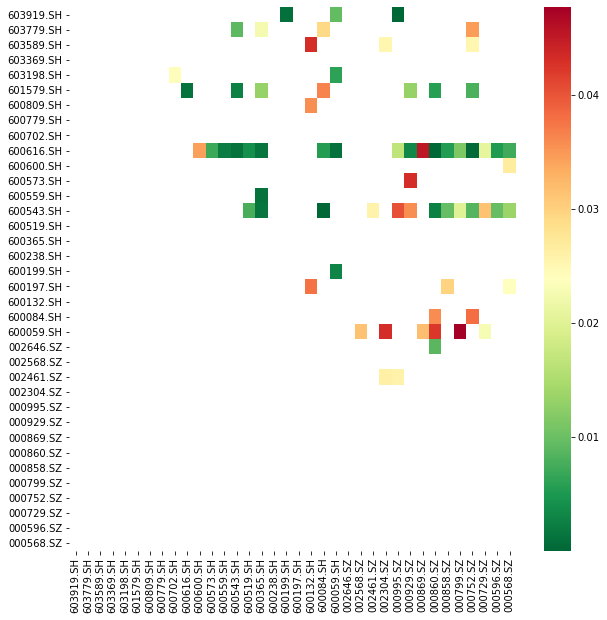

In [4]:
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
df = pd.read_excel('./data/主题行业类/酒类.xlsx', header=1, index_col=0, skiprows=0)
tickers = df.columns
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r', mask=(pvalues >= 0.05))
print(pairs)

In [5]:
window_size = 60
trade_period = 1

envs = []
for pair in pairs:
    data = df[list(pair)].dropna()
    if data.shape[0] > 700:
        envs.append(StockTradingEnvironment(data.copy(), window_size, trade_period))

train_size = int(len(envs) * 0.7)
print(train_size)
train_envs = envs[:train_size]
test_envs = envs[train_size:]

48


In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, input_size, n_actions):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, n_actions)
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        return self.model(x.to(device))

In [8]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
n_actions = 3

policy_net = DQN(window_size + 2, n_actions).to(device)
target_net = DQN(window_size + 2, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-4)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [9]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [10]:
num_episodes = 100
best_rewards = 0.0
for i_episode in range(num_episodes):
    policy_net.train()
    train_rewards = []
    train_returns = []
    for env in train_envs:
        # Initialize the environment and state
        obs = env.reset()
        state = torch.tensor([obs], dtype=torch.float, device=device)
        for t in count():
            # Select and perform an action
            action = select_action(state)
            obs, reward, done, info = env.step(Positions(action.item()))
            reward = torch.tensor([reward], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor([obs], dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            memory.push(state, action, next_state, reward)

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            optimize_model()
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # Validation
    policy_net.eval()
    test_rewards = []
    test_returns = []
    with torch.no_grad():
        for env in test_envs:
            obs = env.reset()
            state = torch.tensor([obs], dtype=torch.float, device=device)
            for t in count():
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)
                obs, _reward, done, info = env.step(Positions(action.item()))
                state = torch.tensor([obs], dtype=torch.float, device=device)

                if done:
                    test_rewards.append(info['total_reward'])
                    test_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(test_rewards)
    if avg_rewards > best_rewards:
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))

    print('epoch [{}/{}], train rewards:{:.4f}, return:{:.4f}, val rewards:{:.4f}, return:{:.4f}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(test_rewards),
           np.mean(test_returns)))


print('Complete')

epoch [1/100], train rewards:-0.2035, return:0.1403, val rewards:-0.2417, return:0.5496
epoch [2/100], train rewards:-0.1964, return:-0.1141, val rewards:-0.2829, return:-0.3731
epoch [3/100], train rewards:-0.1994, return:-0.1187, val rewards:-0.2740, return:-0.1414


KeyboardInterrupt: 

In [ ]:
policy_net.load_state_dict(torch.load('./models/model (19).pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()
target_net.eval()

returns = []
with torch.no_grad():
    for env in test_envs:
        obs = env.reset()
        state = torch.tensor([obs], dtype=torch.float, device=device)
        for t in count():
            # Select and perform an action
            action = policy_net(state).max(1)[1].view(1, 1)
            obs, reward, done, info = env.step(Positions(action.item()))
            state = torch.tensor([obs], dtype=torch.float, device=device)

            if done:
                print(env.returns)
                print(env._total_reward)
                env.render()
                returns.append(info['total_return'])
                break

avg_returns = np.mean(returns)
print(avg_returns)

plt.ioff()
plt.show()